In [1]:
import csv
import cv2
import numpy as np
import pandas as pd
from tensorflow.keras import layers, models
import matplotlib.pyplot as plt

In [2]:
from google.colab import drive

drive.mount("/content/gdrive")

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [3]:
! ls "/content/gdrive/My Drive/Colab Notebooks/data/behavioral cloning"

driving_log.csv  IMG.zip


In [ ]:
!unzip "/content/gdrive/My Drive/Colab Notebooks/data/behavioral cloning/IMG.zip"

In [5]:
dataset = pd.read_csv("/content/gdrive/My Drive/Colab Notebooks/data/behavioral cloning/driving_log.csv", names=["center", "left", "right", "steering", "5", "6", "7"])
dataset.head(3)

,center,left,right,steering,5,6,7
0,C:\Users\mrhum\Desktop\self-driving cars ingen...,C:\Users\mrhum\Desktop\self-driving cars inge...,C:\Users\mrhum\Desktop\self-driving cars inge...,0.0,0.0,0,0.000082
1,C:\Users\mrhum\Desktop\self-driving cars ingen...,C:\Users\mrhum\Desktop\self-driving cars inge...,C:\Users\mrhum\Desktop\self-driving cars inge...,0.0,0.0,0,0.000082
2,C:\Users\mrhum\Desktop\self-driving cars ingen...,C:\Users\mrhum\Desktop\self-driving cars inge...,C:\Users\mrhum\Desktop\self-driving cars inge...,0.0,0.0,0,0.000082


In [6]:
df_0 = dataset[dataset['steering']==0.0]
df_not_0 = dataset[dataset['steering']!=0.0]
df_0_samples = df_0.sample(frac=0.05)
data_balanced = pd.concat([df_not_0, df_0_samples])
data_balanced.head(3)

,center,left,right,steering,5,6,7
13,C:\Users\mrhum\Desktop\self-driving cars ingen...,C:\Users\mrhum\Desktop\self-driving cars inge...,C:\Users\mrhum\Desktop\self-driving cars inge...,-0.189086,1.0,0,2.242988
14,C:\Users\mrhum\Desktop\self-driving cars ingen...,C:\Users\mrhum\Desktop\self-driving cars inge...,C:\Users\mrhum\Desktop\self-driving cars inge...,-0.303517,1.0,0,3.414324
19,C:\Users\mrhum\Desktop\self-driving cars ingen...,C:\Users\mrhum\Desktop\self-driving cars inge...,C:\Users\mrhum\Desktop\self-driving cars inge...,-0.297362,1.0,0,9.356720


In [7]:
df_copy = data_balanced.copy(deep=True)

In [8]:
df_copy.shape

(3996, 7)

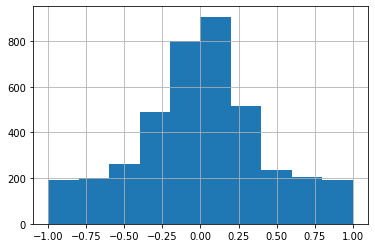

In [9]:
df_copy['steering'].hist()

In [10]:
images = []
measurements = []
for index, row in df_copy.iterrows():
  line = row
  source_path = line["center"]
  filename = source_path.split('\\')[-1]
  current_path = "/content/IMG/" + filename
  image = cv2.imread(current_path)
  if image is not None:
    images.append(image)
    measurement = float(line["steering"])
    measurements.append(measurement)
X_train = np.array(images).astype('float32')
y_train = np.array(measurements).astype('float32')

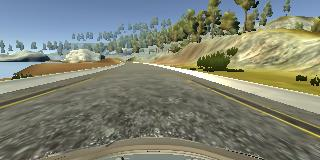

In [11]:
from google.colab.patches import cv2_imshow
cv2_imshow(X_train[0])

My architecture

In [12]:
model = models.Sequential()
model.add(layers.Cropping2D(cropping=((70,25),(0,0)), input_shape=(160,320,3)))
model.add(layers.Lambda(lambda x: x / 255.0 - 0.5))
model.add(layers.Conv2D(128, (5, 5), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(256, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(512, (3, 3), activation='relu'))

model.add(layers.Flatten())
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(1))

model.compile(optimizer='adam',
              loss='mse')

In [13]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
cropping2d (Cropping2D)      (None, 65, 320, 3)        0         
_________________________________________________________________
lambda (Lambda)              (None, 65, 320, 3)        0         
_________________________________________________________________
conv2d (Conv2D)              (None, 61, 316, 128)      9728      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 30, 158, 128)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 28, 156, 256)      295168    
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 14, 78, 256)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 12, 76, 512)       1

In [14]:
model.fit(X_train, y_train, batch_size=128, epochs=5,
         validation_split=0.2, shuffle=True)

Epoch 1/5
25/25 [==============================] - 11s 440ms/step - loss: 2.3745 - val_loss: 0.1296
Epoch 2/5
25/25 [==============================] - 9s 356ms/step - loss: 0.1202 - val_loss: 0.1204
Epoch 3/5
25/25 [==============================] - 9s 358ms/step - loss: 0.1112 - val_loss: 0.1123
Epoch 4/5
25/25 [==============================] - 9s 358ms/step - loss: 0.1086 - val_loss: 0.1079
Epoch 5/5
25/25 [==============================] - 9s 362ms/step - loss: 0.1056 - val_loss: 0.1145


In [15]:
model.save('model.h5')